In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [51]:
expers_to_load = [# Meta V1 model regression
                  (True, "run_20170829_09_48_47_metaV1_40ep_50ops_lr5e05"), # 50ops
                  (False, "run_20170829_09_38_14_metaV7_40ep_50ops_lr5e05"), # incremental learning max 50 ops
                  (False, "run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05"), # stochastic 26 ops
                  # Stick-breaking V1 model
                  (True, "run_20170829_09_29_00_act_sbV3.2_50ep_nu0.5_lr5e05"),
                  (False, "run_20170829_09_21_45_act_sbV3.2_50ep_nu0.6_lr5e05"),
                  (False, "run_20170829_09_10_42_act_sbV3.2_50ep_nu0.7_lr5e05"),
                  (False, "run_20170829_09_01_40_act_sbV3.2_50ep_nu0.8_lr5e05"),
                  (False, "run_20170829_08_53_23_act_sbV3.2_50ep_nu0.85_lr5e05"),
                  (False, "run_20170828_20_17_17_act_sbV3.2_50ep_nu0.9_lr5e05"),
                  (True, "run_20170829_08_29_58_act_sbV3.2_50ep_nu0.95_lr5e05"), # with mean-field+total kl + add remainder to all
                  (False, "run_20170829_08_40_29_act_sbV3.2_50ep_nu0.99_lr5e05"),
                  # the original base act_sbV1 model (no mean field, no time sequence)
                  (True, "run_20170829_10_23_01_act_sbV1_100ep_nu0.5_lr5e05"), # base act_sbV1
                  (True, "run_20170829_10_14_18_act_sbV1_100ep_nu0.95_lr5e05"), # base act_sbV
                  # Graves ACT model
                  (False, "run_20170829_12_24_13_act_gravesV1_50ep_tau0.0003_lr5e05"), # 
                  (False, "run_20170829_13_08_26_act_gravesV1_50ep_tau0.0008_lr5e05"), # 
                  (False, "run_20170829_13_01_16_act_gravesV1_50ep_tau0.003_lr5e05")] # 



In [52]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 200

without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger


INFO - created local logger for experiment with model metaV1_regression_50ops
INFO - INFO - loaded existing model from file logs/run_20170829_09_48_47_metaV1_40ep_50ops_lr5e05/metaV1_regression_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model act_sbV3.2_regression_nu0.5
INFO - INFO - loaded existing model from file logs/run_20170829_09_29_00_act_sbV3.2_50ep_nu0.5_lr5e05/act_sbV3.2_regression_nu0.5.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.f

0 Loading model metaV1_regression_50ops / run_20170829_09_48_47_metaV1_40ep_50ops_lr5e05
1 Loading model act_sbV3.2_regression_nu0.5 (q-prob 0.50) / run_20170829_09_29_00_act_sbV3.2_50ep_nu0.5_lr5e05
2 Loading model act_sbV3.2_regression_nu0.95 (q-prob 0.95) / run_20170829_08_29_58_act_sbV3.2_50ep_nu0.95_lr5e05
3 Loading model act_sbV1_regression_nu0.5 (q-prob 0.50) / run_20170829_10_23_01_act_sbV1_100ep_nu0.5_lr5e05
4 Loading model act_sbV1_regression_nu0.95 (q-prob 0.95) / run_20170829_10_14_18_act_sbV1_100ep_nu0.95_lr5e05


In [57]:
del new_experiments
new_experiments = []


for exper in expers_to_load:
    if exper[0]:
        print("Loading experiment {}".format(exper[1]))
        new_experiments.append(Experiment.load(path_to_exp=exper[1] + "/" + 
                                               "exp_eval_stats_10000_" + str(MAX_EVAL_STEPS) +"steps.dll",
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20170829_09_48_47_metaV1_40ep_50ops_lr5e05
Loading experiment run_20170829_09_29_00_act_sbV3.2_50ep_nu0.5_lr5e05
Loading experiment run_20170829_08_29_58_act_sbV3.2_50ep_nu0.95_lr5e05
Loading experiment run_20170829_10_23_01_act_sbV1_100ep_nu0.5_lr5e05
Loading experiment run_20170829_10_14_18_act_sbV1_100ep_nu0.95_lr5e05
Ready


In [4]:
with open("data/test_regression_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10reg_metaV1_act_sbV1_act_sbV3.2_1_50.png


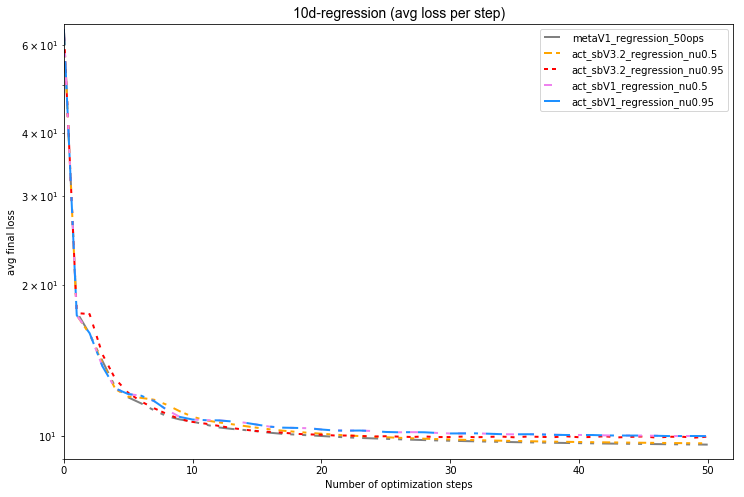

In [62]:
# new_exp_select = [new_experiments[0], new_experiments[5], new_experiments[6], new_experiments[7], new_experiments[8]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10reg_metaV1_act_sbV1_act_sbV3.2_1_50", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=50,
                                              sort_exper="10d-regression",
                                              log_scale=True,
                                              y_lim=[9, 66],
                                              with_stddev=False,
                                              runID=None)

INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.9_08:58:01.png


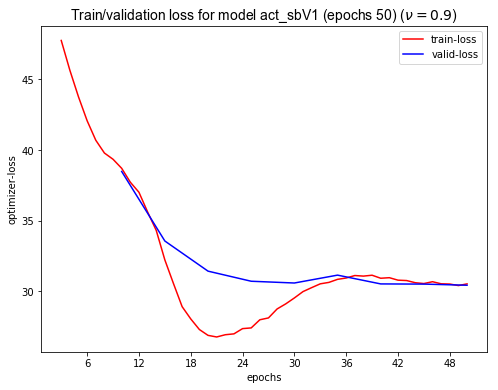

In [5]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [54]:
exp_idx = 4
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV1_regression_nu0.95 with q-prob 0.950


INFO - ! - Validation last step 7 - !
INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 64.415  17.37   16.002  13.745  12.421  12.107  12.017  11.727  11.261
  10.904  10.774  10.742  10.733  10.682  10.624  10.525  10.428  10.381
  10.368  10.354  10.293  10.247  10.239  10.244  10.221  10.177  10.162
  10.169  10.162  10.132  10.108  10.111  10.113  10.096  10.074  10.067
  10.073  10.063  10.046  10.037  10.038  10.037  10.02   10.012  10.012
  10.012  10.001   9.988   9.989   9.991   9.984   9.971   9.966   9.972
   9.971   9.958   9.949   9.951   9.956   9.95    9.937   9.934   9.938
   9.94    9.93    9.921   9.923   9.926   9.923   9.914   9.91    9.913
   9.913   9.908   9.903   9.902   9.903   9.901   9.896   9.894   9.894
   9.893   9.889   9.887   9.888   9.886   9.883   9.88    9.88    9.881
   9.877   9.874   9.873   9.874   9.874   9.869   9.867   9.868   9.868
   9.866   9.862   9.861   9.862   9.861   9.859   9.856   9.856   9.856
   9.854   9.853   9.8

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [16]:

exp_idx = 0
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_50ops with 10000 functions


Validating model metaV1_regression_50ops with q-prob 0.500


INFO - INFO - Epoch 400, elapsed time 7.96 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 2.005e+03/9.396/0.2067
INFO - INFO - Epoch 400: Final step losses: [ 64.415  17.634  15.952  14.081  12.497  11.925  11.602  11.241  10.939
  10.779  10.673  10.527  10.394  10.323  10.27   10.207  10.142  10.089
  10.055  10.024   9.991   9.957   9.927   9.903   9.882   9.862   9.842
   9.823   9.806   9.79    9.776   9.762   9.749   9.737   9.725   9.714
   9.704   9.695   9.685   9.677   9.669   9.661   9.653   9.646   9.64
   9.633   9.627   9.621   9.615   9.61    9.605   9.6     9.595   9.591
   9.586   9.582   9.578   9.574   9.57    9.567   9.563   9.56    9.556
   9.553   9.55    9.547   9.544   9.541   9.538   9.536   9.533   9.53
   9.528   9.525   9.523   9.521   9.519   9.516   9.514   9.512   9.51
   9.508   9.506   9.504   9.502   9.5     9.498   9.497   9.495   9.493
   9.492   9.49    9.488   9.487   9.485   9.484  

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


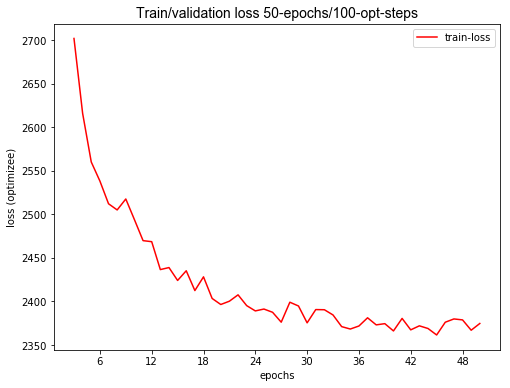

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


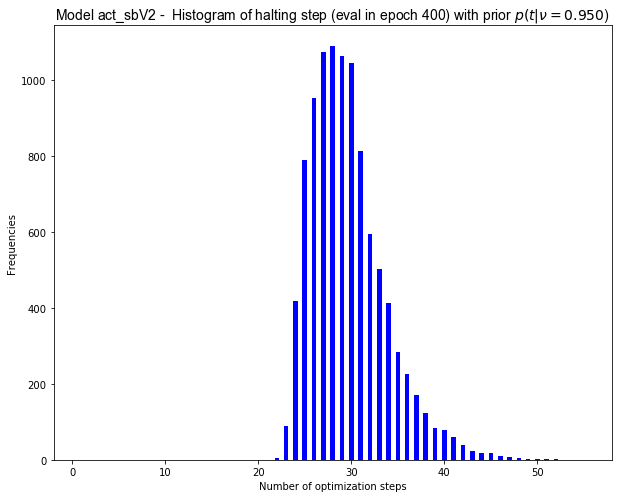

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

INFO - Successfully saved fig logs/run_20170829_10_14_18_act_sbV1_100ep_nu0.95_lr5e05/halting_step_versus_nll_distance.png


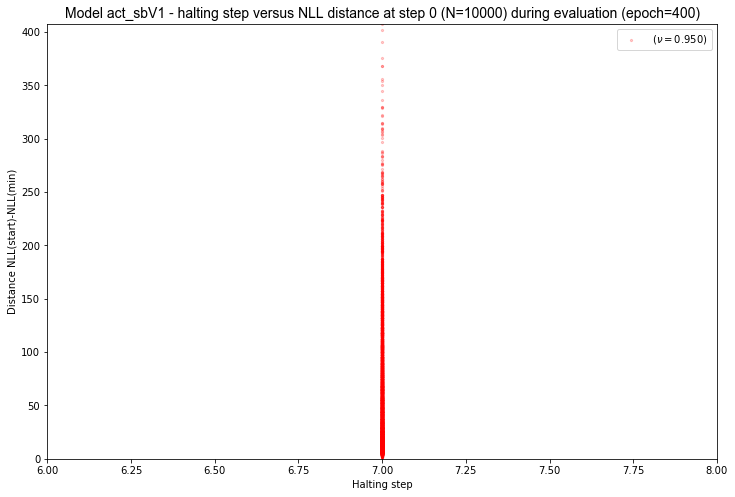

In [56]:
plot_loss_versus_halting_step(new_experiments[4], epoch=400, do_show=True, do_save=True)

In [47]:
new_experiments[3].val_stats["halt_step_funcs"][400]

array([ 41.,  51.,  36., ...,  51.,  58.,  45.], dtype=float32)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


In [ ]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [5]:
funcs = RegressionFunction(n_funcs=10, n_samples=10, stddev=1., x_dim=5, use_cuda=True, 
                                calc_true_params=False)
print(funcs.true_minimum_nll)

Variable containing:
 9.1894
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [3]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [11]:
experiments[3].generate_figures()

INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/eval_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_qts_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_halting_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/qt_values_train_act_sbV1_50ep_nu0.